<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask Ecosystem

In this tutorial so far we've covered:

- Parallelizing general computations with `dask.delayed`
- Parallelizing tabular computations `dask.dataframe`
- Using the different local schedulers
- Profiling the local schedulers using the tools in `dask.diagnostics`
- Using the distributed scheduler in `dask.distributed`

This provides a solid foundation, but `dask` and the `dask` ecosystem are much larger than these topics alone.

In this notebook we provide a whirlwind tour of a few things we've missed, as well as links to where to you can find out more about them.

---

## Dask Array

`dask.array` is another dask collection found inside the core `dask` library. Just as `dask.dataframe` mirrors `pandas`, `dask.array` mirrors `numpy`. Arrays are split into multiple *chunks* along each axis. And oerations are parallelized along the *chunks*.

Much of the commonly used numpy api is implemented, including:

- Elementwise operations
- Standard ufuns
- Indexing
- Reductions
- Some linear algebra (`da.linalg`)
- Fourier Transforms (`da.fft`)
- ...

Here we create a random `dask.array`, and use the `dot` operator to peform a matrix multiplication.

For more information on `dask.array`, see the [documentation](http://dask.pydata.org/en/latest/array.html).

In [1]:
import dask.array as da

# Create a random array of shape (10000, 10000),
# broken into 4 (5000, 5000) chunks
x = da.random.normal(size=(10000, 10000), chunks=(5000, 5000))

# Perform a matrix multiplication with the transpose,
# and then take the mean of the result
res = x.dot(x.T).mean()

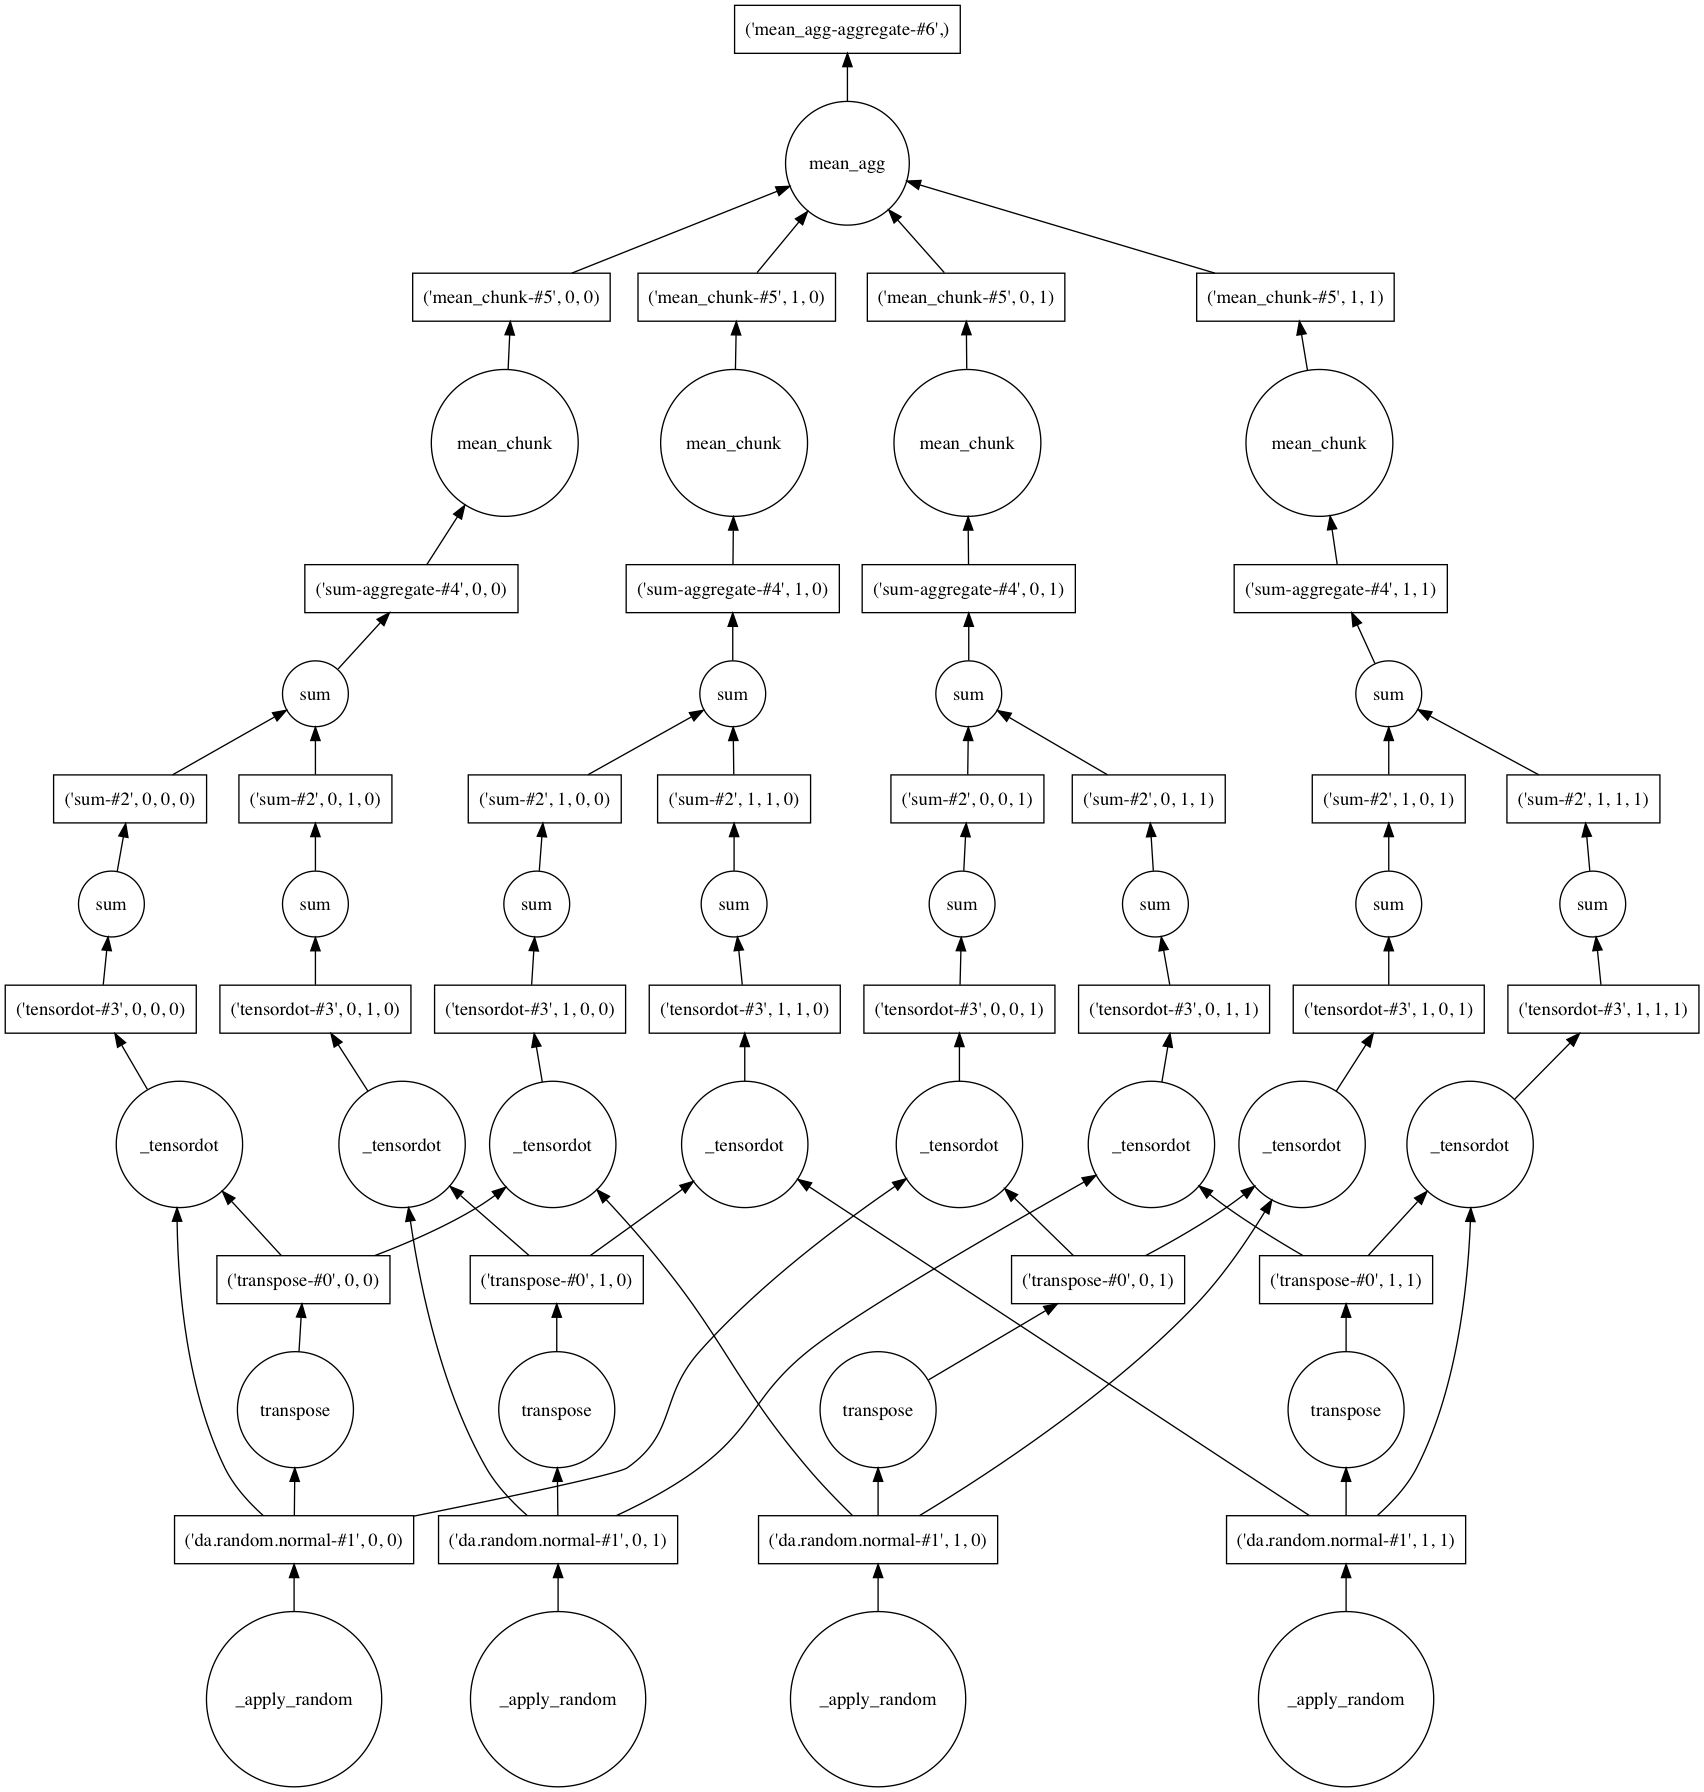

In [2]:
# Look at the resulting graph
res.visualize()

In [3]:
# Compute the result
res.compute()

1.0203578383331382

---

## Dask Bag

[`dask.bag`](http://dask.readthedocs.io/en/latest/bag.html) is another builtin dask collection. It implements operations like ``map``, ``filter``, ``fold``, and ``groupby`` on collections of Python objects.  It does this in parallel and in small memory using Python iterators.  It is similar to a parallel version of [`toolz`](http://toolz.readthedocs.org/) or a Pythonic version of the [PySpark RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html).

Dask bag can be useful for working with non-structured data such as `json`, or for pre-processing data before transforming into a more structured collection like `dask.dataframe`.

Here we read in some line-delimited json flight data as a `dask.bag`, pull out a few fields, and then convert the result to a `dask.dataframe`:

In [4]:
import dask.bag as db
import os

b = db.read_text(os.path.join('data', 'flightjson', '*.json'))
b

ValueError: ('No files found', 'data/flightjson/*.json')

In [ ]:
# Look at the first element in the bag
b.take(1)

In [ ]:
try:
    # ujson is faster, use it if available
    import ujson as json
except:
    import json
    
columns = ['Year', 'Month', 'DayofMonth', 'DepDelay', 'Origin']

df = (b.map(json.loads)                 # Convert each json blob to a dictionary
       .pluck(columns)                  # Pluck out only the fields we want
       .to_dataframe(columns=columns))  # Convert the result to a dask.dataframe

In [ ]:
df

In [ ]:
df.head()

---

## Tools for Setting up Clusters

There are a number of libraries/tools in the larger ecosystem for working with the core `dask` and `distributed` libraries. Several of these are to ease setting up a `dask.distributed` cluster for certain environments. Here we list a few with links:

- [`dask-ec2`](https://github.com/dask/dask-ec2)
- [`dask-kubernetes`](https://github.com/martindurant/dask-kubernetes)
- [`dask-yarn`](https://github.com/dask/dask-yarn)
- [`dask-drmaa`](https://github.com/dask/dask-drmaa)
- [`dask-marathon`](https://github.com/mrocklin/dask-marathon)

---

## Machine Learning

There are currently several ways dask can help with machine learning:

- The `dask.distributed` [joblib backend](http://distributed.readthedocs.io/en/latest/joblib.html) for parallelizing existing Scikit-Learn code.
- [`dask-searchcv`](http://dask-searchcv.readthedocs.io/) for parallel and distributed hyperparameter searches
- [`dask-glm`](https://github.com/dask/dask-glm) for parallel and distributed Generalized Linear Models
- [`dask-xgboost`](https://github.com/dask/dask-xgboost) and [`dask-tensorflow`](https://github.com/dask/dask-tensorflow) for setting up and using `xgboost` and `tensorflow` in a distributed environment.

Here we give a bit more details on a few of these:

### Dask Distributed Joblib Backend

This allows parallelizing [existing joblib code](https://pythonhosted.org/joblib/) across a `dask.distributed` cluster. For example, to parallelize `GridSearchCV` from Scikit-Learn:

```python
import distributed.joblib
from sklearn.externals.joblib import parallel_backend
from sklearn import GridSearchCV

search = GridSearchCV(...)

# Parallelize the search across a cluster
with parallel_backend('dask.distributed', 'your-scheduler-address'):
    search.fit(X, y)
```

A few caveats:
- Currently this only works with a few scikit-learn operations, as many Scikit-Learn estimators hard-code which joblib backend they can use. Work is being done currently to improve this.
- This only allows computations to scale across a cluster - it doesn't help when your data won't fit on a single machine.
- This works best when the compute:data ratio is high, as your arrays will be serialized between workers.

### Dask-SearchCV

This provides drop-in replacements for Scikit-Learn's `GridSearchCV` and `RandomizedSearchCV`, with the parallelism implemented using `dask` instead of `joblib`.

The benefits of using this instead of the joblib backend described above are:

- Ability to use remote data. The joblib backend requires that your data is on the client (your computer), whereas `dask-searchcv` allows it to be only on the cluster.
- Works seemlessly with dask collections. You can pass `dask.array`, `dask.dataframe`, or `dask.delayed` objects to `fit`, and `dask-searchcv` does the right thing. Note that this *doesn't* make calling `fit` work better with larger datasets - the input data will still be fully realized on each worker.
- When searching across a `sklearn.pipeline.Pipeline`, `dask-searchcv` can merge duplicate computations, avoiding expensive repeated work.

Being a drop-in for scikit-learn's versions, often only an import change is needed.

```python
# from sklearn.model_selection import GridSearchCV
from dask_searchcv import GridSearchCV

search = GridSearchCV(...)
search.fit(X, y)
```

---

## Libraries that use Dask

Dask has been integrated into a few other projects as a way to parallelize existing code. Here we briefly list just a few of them:

### Xarray

[`xarray`](xarray.pydata.org) is a library for working with labelled ND-arrays, with a focus on earth and climate science. It optionally uses `dask.array` as a backend for working with large out-of-core datasets. Work is ongoing to expand this to work with `dask.distributed`, allowing `xarray` to scale across a cluster.

### Scikit-Image

[`Scikit-Image`](https://github.com/scikit-image/scikit-image/) optionally uses `dask.array` to parallelize image filtering operations.

### Apache Airflow

[`Apache Airflow`](https://github.com/apache/incubator-airflow) recently added support for using `dask.distributed` as a backend.

### DataShader

[`datashader`](http://datashader.readthedocs.org/) is a library for plotting larger datasets. It optionally uses dask to support out-of-core and distributed datasets.